In [1]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [ ]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

running_on_kaggle = True

if running_on_kaggle:
    train_file = np.load("/kaggle/input/cse-251-b-2025/train.npz")
    test_file = np.load("/kaggle/input/cse-251-b-2025/test_input.npz")
else:
    train_file = np.load("./cse-251-b-2025/train.npz")
    test_file = np.load("./cse-251-b-2025/test_input.npz")

train_data = train_file['data']
test_data = test_file['data']

print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [3]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [4]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [5]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [6]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(BaseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [7]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [8]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(LSTMWithMLP, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [10]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [11]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [12]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [13]:
from multiprocessing import Pool

# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 64
num_folds: int = 4
early_stopping_patience: int = 40
early_stopping_threshold: float = 1e-5
epochs: int = 300
starting_lr: float = 1e-2
scale: float = 10.0
weight_decay: float = 1e-2

lstm_hidden_dim: int = 128

# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    # return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds, test_size=int(0.15 * len(full_training_data)))

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")
    overall_best_seen_at = (0, 0) #(epoch, fold)

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            lr_scheduler.MultiStepLR(
                optimizer,
                milestones= list(range(25, epochs, 25)),
                gamma=0.80,
            ),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(100, epochs, 100)),
            #     gamma=0.5,
            # ),
            lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max= int(epochs * 0.9),
                # T_0 = 50,
                # T_mult = 2,
                eta_min=1e-6
            ),
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    overall_best_seen_at = (epoch + 1, fold_i + 1)
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                sched.step()

        # Clean up after the fold finishes to prevent slower folds later
        # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879
        torch.cuda.empty_cache()
        del train_dataloader, train_dataset, val_dataloader, val_dataset

    print(f"BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: {overall_best_val_loss}, AT (epoch, fold) = {overall_best_seen_at}")

# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)

# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")


FOLD 1/4 ==================================


Epoch:   2%|▏         | 5/300 [00:46<45:32,  9.26s/epoch]

Epoch 005 | Learning rate 0.009796 | train normalized MSE   0.2609 | val normalized MSE   0.2890, | val MAE   3.0736 | val MSE  28.8967


Epoch:   3%|▎         | 10/300 [01:22<31:46,  6.57s/epoch]

Epoch 010 | Learning rate 0.009533 | train normalized MSE   0.2101 | val normalized MSE   0.2246, | val MAE   2.7588 | val MSE  22.4607


Epoch:   5%|▌         | 15/300 [02:01<39:06,  8.23s/epoch]

Epoch 015 | Learning rate 0.009261 | train normalized MSE   0.1951 | val normalized MSE   0.1548, | val MAE   2.1645 | val MSE  15.4794


Epoch:   7%|▋         | 20/300 [02:30<24:26,  5.24s/epoch]

Epoch 020 | Learning rate 0.008981 | train normalized MSE   0.1732 | val normalized MSE   0.1118, | val MAE   1.6800 | val MSE  11.1822


Epoch:   8%|▊         | 25/300 [02:57<28:56,  6.31s/epoch]

Epoch 025 | Learning rate 0.008695 | train normalized MSE   0.1632 | val normalized MSE   0.1281, | val MAE   1.8826 | val MSE  12.8122


Epoch:  10%|█         | 30/300 [03:28<23:37,  5.25s/epoch]

Epoch 030 | Learning rate 0.006723 | train normalized MSE   0.1578 | val normalized MSE   0.1257, | val MAE   1.9012 | val MSE  12.5682


Epoch:  12%|█▏        | 35/300 [03:44<16:00,  3.63s/epoch]

Epoch 035 | Learning rate 0.006486 | train normalized MSE   0.1335 | val normalized MSE   0.1068, | val MAE   1.6661 | val MSE  10.6766


Epoch:  13%|█▎        | 40/300 [04:00<14:08,  3.26s/epoch]

Epoch 040 | Learning rate 0.006247 | train normalized MSE   0.1286 | val normalized MSE   0.1067, | val MAE   1.6496 | val MSE  10.6713


Epoch:  15%|█▌        | 45/300 [04:16<14:00,  3.30s/epoch]

Epoch 045 | Learning rate 0.006005 | train normalized MSE   0.1348 | val normalized MSE   0.1040, | val MAE   1.6123 | val MSE  10.4049


Epoch:  17%|█▋        | 50/300 [04:33<14:08,  3.40s/epoch]

Epoch 050 | Learning rate 0.005763 | train normalized MSE   0.1442 | val normalized MSE   0.1263, | val MAE   1.9624 | val MSE  12.6329


Epoch:  18%|█▊        | 55/300 [04:50<13:36,  3.33s/epoch]

Epoch 055 | Learning rate 0.004416 | train normalized MSE   0.1288 | val normalized MSE   0.1204, | val MAE   1.8338 | val MSE  12.0402


Epoch:  20%|██        | 60/300 [05:07<13:21,  3.34s/epoch]

Epoch 060 | Learning rate 0.004222 | train normalized MSE   0.1273 | val normalized MSE   0.0975, | val MAE   1.5513 | val MSE   9.7451


Epoch:  22%|██▏       | 65/300 [05:24<13:16,  3.39s/epoch]

Epoch 065 | Learning rate 0.004029 | train normalized MSE   0.1190 | val normalized MSE   0.1097, | val MAE   1.7226 | val MSE  10.9720


Epoch:  23%|██▎       | 70/300 [05:41<13:18,  3.47s/epoch]

Epoch 070 | Learning rate 0.003837 | train normalized MSE   0.1227 | val normalized MSE   0.0930, | val MAE   1.4872 | val MSE   9.2990


Epoch:  25%|██▌       | 75/300 [05:58<12:45,  3.40s/epoch]

Epoch 075 | Learning rate 0.003647 | train normalized MSE   0.1156 | val normalized MSE   0.1009, | val MAE   1.6222 | val MSE  10.0912


Epoch:  27%|██▋       | 80/300 [06:14<12:07,  3.31s/epoch]

Epoch 080 | Learning rate 0.002768 | train normalized MSE   0.1099 | val normalized MSE   0.1019, | val MAE   1.5896 | val MSE  10.1880


Epoch:  28%|██▊       | 85/300 [06:31<12:09,  3.39s/epoch]

Epoch 085 | Learning rate 0.002620 | train normalized MSE   0.1047 | val normalized MSE   0.0904, | val MAE   1.4583 | val MSE   9.0381


Epoch:  30%|███       | 90/300 [06:48<11:38,  3.32s/epoch]

Epoch 090 | Learning rate 0.002475 | train normalized MSE   0.1083 | val normalized MSE   0.0965, | val MAE   1.5520 | val MSE   9.6522


Epoch:  32%|███▏      | 95/300 [07:05<11:29,  3.37s/epoch]

Epoch 095 | Learning rate 0.002332 | train normalized MSE   0.1022 | val normalized MSE   0.0924, | val MAE   1.4865 | val MSE   9.2418


Epoch:  33%|███▎      | 100/300 [07:22<11:16,  3.38s/epoch]

Epoch 100 | Learning rate 0.002193 | train normalized MSE   0.1018 | val normalized MSE   0.0909, | val MAE   1.4441 | val MSE   9.0903


Epoch:  35%|███▌      | 105/300 [07:39<11:00,  3.39s/epoch]

Epoch 105 | Learning rate 0.001645 | train normalized MSE   0.0994 | val normalized MSE   0.0959, | val MAE   1.5357 | val MSE   9.5926


Epoch:  37%|███▋      | 110/300 [07:56<11:07,  3.51s/epoch]

Epoch 110 | Learning rate 0.001539 | train normalized MSE   0.0951 | val normalized MSE   0.0949, | val MAE   1.5432 | val MSE   9.4927


Epoch:  38%|███▊      | 115/300 [08:37<23:23,  7.59s/epoch]

Epoch 115 | Learning rate 0.001437 | train normalized MSE   0.0983 | val normalized MSE   0.0913, | val MAE   1.4815 | val MSE   9.1260


Epoch:  40%|████      | 120/300 [09:04<16:45,  5.59s/epoch]

Epoch 120 | Learning rate 0.001337 | train normalized MSE   0.0977 | val normalized MSE   0.0897, | val MAE   1.4653 | val MSE   8.9664


Epoch:  42%|████▏     | 125/300 [09:32<13:55,  4.77s/epoch]

Epoch 125 | Learning rate 0.001241 | train normalized MSE   0.0926 | val normalized MSE   0.0885, | val MAE   1.4341 | val MSE   8.8527


Epoch:  43%|████▎     | 130/300 [09:48<09:44,  3.44s/epoch]

Epoch 130 | Learning rate 0.000918 | train normalized MSE   0.0941 | val normalized MSE   0.0884, | val MAE   1.4341 | val MSE   8.8364


Epoch:  45%|████▌     | 135/300 [10:04<08:53,  3.23s/epoch]

Epoch 135 | Learning rate 0.000847 | train normalized MSE   0.0980 | val normalized MSE   0.0877, | val MAE   1.4220 | val MSE   8.7738


Epoch:  47%|████▋     | 140/300 [10:21<08:51,  3.32s/epoch]

Epoch 140 | Learning rate 0.000779 | train normalized MSE   0.0910 | val normalized MSE   0.0895, | val MAE   1.4829 | val MSE   8.9538


Epoch:  48%|████▊     | 145/300 [10:38<08:46,  3.40s/epoch]

Epoch 145 | Learning rate 0.000713 | train normalized MSE   0.0916 | val normalized MSE   0.0896, | val MAE   1.4605 | val MSE   8.9600


Epoch:  50%|█████     | 150/300 [10:55<08:25,  3.37s/epoch]

Epoch 150 | Learning rate 0.000651 | train normalized MSE   0.0902 | val normalized MSE   0.0888, | val MAE   1.4457 | val MSE   8.8759


Epoch:  52%|█████▏    | 155/300 [11:12<08:11,  3.39s/epoch]

Epoch 155 | Learning rate 0.000473 | train normalized MSE   0.0914 | val normalized MSE   0.0881, | val MAE   1.4448 | val MSE   8.8144


Epoch:  53%|█████▎    | 160/300 [11:29<07:58,  3.41s/epoch]

Epoch 160 | Learning rate 0.000428 | train normalized MSE   0.0849 | val normalized MSE   0.0875, | val MAE   1.4290 | val MSE   8.7481


Epoch:  55%|█████▌    | 165/300 [11:46<07:42,  3.43s/epoch]

Epoch 165 | Learning rate 0.000386 | train normalized MSE   0.0898 | val normalized MSE   0.0909, | val MAE   1.5110 | val MSE   9.0886


Epoch:  57%|█████▋    | 170/300 [12:03<07:19,  3.38s/epoch]

Epoch 170 | Learning rate 0.000346 | train normalized MSE   0.0883 | val normalized MSE   0.0909, | val MAE   1.4990 | val MSE   9.0909


Epoch:  58%|█████▊    | 175/300 [12:20<07:07,  3.42s/epoch]

Epoch 175 | Learning rate 0.000308 | train normalized MSE   0.0858 | val normalized MSE   0.0885, | val MAE   1.4525 | val MSE   8.8485


Epoch:  60%|██████    | 180/300 [12:37<06:45,  3.38s/epoch]

Epoch 180 | Learning rate 0.000219 | train normalized MSE   0.0857 | val normalized MSE   0.0868, | val MAE   1.4261 | val MSE   8.6848


Epoch:  62%|██████▏   | 185/300 [12:54<06:39,  3.47s/epoch]

Epoch 185 | Learning rate 0.000192 | train normalized MSE   0.0883 | val normalized MSE   0.0871, | val MAE   1.4367 | val MSE   8.7127


Epoch:  63%|██████▎   | 190/300 [13:18<09:40,  5.28s/epoch]

Epoch 190 | Learning rate 0.000168 | train normalized MSE   0.0867 | val normalized MSE   0.0877, | val MAE   1.4362 | val MSE   8.7699


Epoch:  65%|██████▌   | 195/300 [14:01<14:00,  8.01s/epoch]

Epoch 195 | Learning rate 0.000146 | train normalized MSE   0.0849 | val normalized MSE   0.0878, | val MAE   1.4462 | val MSE   8.7806


Epoch:  67%|██████▋   | 200/300 [14:33<11:07,  6.68s/epoch]

Epoch 200 | Learning rate 0.000125 | train normalized MSE   0.0892 | val normalized MSE   0.0874, | val MAE   1.4328 | val MSE   8.7417


Epoch:  68%|██████▊   | 203/300 [14:47<07:04,  4.37s/epoch]

==== EARLY STOP at epoch 204

FOLD 2/4 ==================================



Epoch:   2%|▏         | 5/300 [00:33<31:11,  6.35s/epoch]

Epoch 005 | Learning rate 0.009796 | train normalized MSE   0.2594 | val normalized MSE   0.2271, | val MAE   2.4966 | val MSE  22.7066


Epoch:   3%|▎         | 10/300 [01:30<51:30, 10.66s/epoch]

Epoch 010 | Learning rate 0.009533 | train normalized MSE   0.1999 | val normalized MSE   0.1836, | val MAE   2.3743 | val MSE  18.3617


Epoch:   5%|▌         | 15/300 [02:25<52:18, 11.01s/epoch]

Epoch 015 | Learning rate 0.009261 | train normalized MSE   0.1657 | val normalized MSE   0.1521, | val MAE   2.0629 | val MSE  15.2055


Epoch:   7%|▋         | 20/300 [03:20<51:10, 10.96s/epoch]

Epoch 020 | Learning rate 0.008981 | train normalized MSE   0.1483 | val normalized MSE   0.1213, | val MAE   1.7836 | val MSE  12.1339


Epoch:   8%|▊         | 25/300 [04:11<46:03, 10.05s/epoch]

Epoch 025 | Learning rate 0.008695 | train normalized MSE   0.1546 | val normalized MSE   0.1379, | val MAE   1.9409 | val MSE  13.7896


Epoch:  10%|█         | 30/300 [04:33<23:41,  5.27s/epoch]

Epoch 030 | Learning rate 0.006723 | train normalized MSE   0.1474 | val normalized MSE   0.1339, | val MAE   1.8717 | val MSE  13.3879


Epoch:  12%|█▏        | 35/300 [05:17<40:10,  9.10s/epoch]

Epoch 035 | Learning rate 0.006486 | train normalized MSE   0.1364 | val normalized MSE   0.1132, | val MAE   1.5999 | val MSE  11.3240


Epoch:  13%|█▎        | 40/300 [06:04<40:22,  9.32s/epoch]

Epoch 040 | Learning rate 0.006247 | train normalized MSE   0.1302 | val normalized MSE   0.1150, | val MAE   1.6308 | val MSE  11.5026


Epoch:  15%|█▌        | 45/300 [06:25<21:33,  5.07s/epoch]

Epoch 045 | Learning rate 0.006005 | train normalized MSE   0.1303 | val normalized MSE   0.1190, | val MAE   1.7048 | val MSE  11.9045


Epoch:  17%|█▋        | 50/300 [06:47<18:25,  4.42s/epoch]

Epoch 050 | Learning rate 0.005763 | train normalized MSE   0.1235 | val normalized MSE   0.1106, | val MAE   1.6064 | val MSE  11.0561


Epoch:  18%|█▊        | 55/300 [07:14<21:29,  5.26s/epoch]

Epoch 055 | Learning rate 0.004416 | train normalized MSE   0.1142 | val normalized MSE   0.1176, | val MAE   1.7341 | val MSE  11.7582


Epoch:  20%|██        | 60/300 [07:36<18:03,  4.51s/epoch]

Epoch 060 | Learning rate 0.004222 | train normalized MSE   0.1120 | val normalized MSE   0.1058, | val MAE   1.5118 | val MSE  10.5845


Epoch:  22%|██▏       | 65/300 [07:59<18:19,  4.68s/epoch]

Epoch 065 | Learning rate 0.004029 | train normalized MSE   0.1130 | val normalized MSE   0.1201, | val MAE   1.7596 | val MSE  12.0067


Epoch:  23%|██▎       | 70/300 [08:24<18:45,  4.89s/epoch]

Epoch 070 | Learning rate 0.003837 | train normalized MSE   0.1119 | val normalized MSE   0.1195, | val MAE   1.7178 | val MSE  11.9542


Epoch:  25%|██▌       | 75/300 [08:48<18:35,  4.96s/epoch]

Epoch 075 | Learning rate 0.003647 | train normalized MSE   0.1067 | val normalized MSE   0.1112, | val MAE   1.5903 | val MSE  11.1155


Epoch:  27%|██▋       | 80/300 [09:15<19:23,  5.29s/epoch]

Epoch 080 | Learning rate 0.002768 | train normalized MSE   0.1022 | val normalized MSE   0.1037, | val MAE   1.4901 | val MSE  10.3722


Epoch:  28%|██▊       | 85/300 [09:50<25:24,  7.09s/epoch]

Epoch 085 | Learning rate 0.002620 | train normalized MSE   0.0987 | val normalized MSE   0.1038, | val MAE   1.4981 | val MSE  10.3797


Epoch:  30%|███       | 90/300 [10:18<20:23,  5.82s/epoch]

Epoch 090 | Learning rate 0.002475 | train normalized MSE   0.1003 | val normalized MSE   0.1050, | val MAE   1.5294 | val MSE  10.5004


Epoch:  32%|███▏      | 95/300 [10:47<22:43,  6.65s/epoch]

Epoch 095 | Learning rate 0.002332 | train normalized MSE   0.0978 | val normalized MSE   0.1097, | val MAE   1.6233 | val MSE  10.9740


Epoch:  33%|███▎      | 100/300 [11:41<34:07, 10.24s/epoch]

Epoch 100 | Learning rate 0.002193 | train normalized MSE   0.0983 | val normalized MSE   0.1067, | val MAE   1.5775 | val MSE  10.6658


Epoch:  35%|███▌      | 105/300 [12:39<36:48, 11.33s/epoch]

Epoch 105 | Learning rate 0.001645 | train normalized MSE   0.0939 | val normalized MSE   0.1058, | val MAE   1.5853 | val MSE  10.5821


Epoch:  37%|███▋      | 110/300 [13:18<24:18,  7.68s/epoch]

Epoch 110 | Learning rate 0.001539 | train normalized MSE   0.0908 | val normalized MSE   0.1032, | val MAE   1.4923 | val MSE  10.3172


Epoch:  38%|███▊      | 115/300 [14:04<29:12,  9.47s/epoch]

Epoch 115 | Learning rate 0.001437 | train normalized MSE   0.0907 | val normalized MSE   0.1029, | val MAE   1.5397 | val MSE  10.2909


Epoch:  40%|████      | 120/300 [15:01<33:15, 11.09s/epoch]

Epoch 120 | Learning rate 0.001337 | train normalized MSE   0.0938 | val normalized MSE   0.0995, | val MAE   1.4448 | val MSE   9.9503


Epoch:  42%|████▏     | 125/300 [15:58<32:57, 11.30s/epoch]

Epoch 125 | Learning rate 0.001241 | train normalized MSE   0.0937 | val normalized MSE   0.0990, | val MAE   1.4997 | val MSE   9.8986


Epoch:  43%|████▎     | 130/300 [16:31<19:56,  7.04s/epoch]

Epoch 130 | Learning rate 0.000918 | train normalized MSE   0.0866 | val normalized MSE   0.1046, | val MAE   1.5814 | val MSE  10.4565


Epoch:  45%|████▌     | 135/300 [17:05<17:13,  6.27s/epoch]

Epoch 135 | Learning rate 0.000847 | train normalized MSE   0.0889 | val normalized MSE   0.1001, | val MAE   1.5023 | val MSE  10.0106


Epoch:  47%|████▋     | 140/300 [17:31<14:05,  5.28s/epoch]

Epoch 140 | Learning rate 0.000779 | train normalized MSE   0.0867 | val normalized MSE   0.1020, | val MAE   1.5546 | val MSE  10.1979


Epoch:  48%|████▊     | 145/300 [18:10<21:53,  8.47s/epoch]

Epoch 145 | Learning rate 0.000713 | train normalized MSE   0.0848 | val normalized MSE   0.1041, | val MAE   1.5739 | val MSE  10.4082


Epoch:  50%|█████     | 150/300 [19:09<28:20, 11.33s/epoch]

Epoch 150 | Learning rate 0.000651 | train normalized MSE   0.0881 | val normalized MSE   0.1014, | val MAE   1.5713 | val MSE  10.1380


Epoch:  52%|█████▏    | 155/300 [20:07<27:50, 11.52s/epoch]

Epoch 155 | Learning rate 0.000473 | train normalized MSE   0.0831 | val normalized MSE   0.0992, | val MAE   1.4854 | val MSE   9.9154


Epoch:  53%|█████▎    | 160/300 [21:04<26:47, 11.49s/epoch]

Epoch 160 | Learning rate 0.000428 | train normalized MSE   0.0833 | val normalized MSE   0.0998, | val MAE   1.5307 | val MSE   9.9800


Epoch:  55%|█████▌    | 165/300 [21:45<19:44,  8.77s/epoch]

Epoch 165 | Learning rate 0.000386 | train normalized MSE   0.0824 | val normalized MSE   0.0986, | val MAE   1.5070 | val MSE   9.8580


Epoch:  57%|█████▋    | 170/300 [22:37<23:30, 10.85s/epoch]

Epoch 170 | Learning rate 0.000346 | train normalized MSE   0.0837 | val normalized MSE   0.1023, | val MAE   1.5535 | val MSE  10.2292


Epoch:  58%|█████▊    | 175/300 [23:34<22:55, 11.01s/epoch]

Epoch 175 | Learning rate 0.000308 | train normalized MSE   0.0819 | val normalized MSE   0.0988, | val MAE   1.4975 | val MSE   9.8783


Epoch:  60%|██████    | 180/300 [23:55<10:42,  5.35s/epoch]

Epoch 180 | Learning rate 0.000219 | train normalized MSE   0.0780 | val normalized MSE   0.1008, | val MAE   1.5415 | val MSE  10.0808


Epoch:  62%|██████▏   | 185/300 [24:17<08:30,  4.43s/epoch]

Epoch 185 | Learning rate 0.000192 | train normalized MSE   0.0797 | val normalized MSE   0.0984, | val MAE   1.5079 | val MSE   9.8369


Epoch:  63%|██████▎   | 190/300 [24:39<08:10,  4.46s/epoch]

Epoch 190 | Learning rate 0.000168 | train normalized MSE   0.0841 | val normalized MSE   0.0992, | val MAE   1.5077 | val MSE   9.9212


Epoch:  64%|██████▍   | 192/300 [25:01<14:04,  7.82s/epoch]

==== EARLY STOP at epoch 193

FOLD 3/4 ==================================



Epoch:   2%|▏         | 5/300 [01:09<1:09:11, 14.07s/epoch]

Epoch 005 | Learning rate 0.009796 | train normalized MSE   0.2616 | val normalized MSE   0.1885, | val MAE   2.3351 | val MSE  18.8516


Epoch:   3%|▎         | 10/300 [02:21<1:08:38, 14.20s/epoch]

Epoch 010 | Learning rate 0.009533 | train normalized MSE   0.1842 | val normalized MSE   0.1630, | val MAE   2.2826 | val MSE  16.3021


Epoch:   5%|▌         | 15/300 [03:10<48:31, 10.22s/epoch]  

Epoch 015 | Learning rate 0.009261 | train normalized MSE   0.1704 | val normalized MSE   0.1295, | val MAE   1.9491 | val MSE  12.9459


Epoch:   7%|▋         | 20/300 [03:57<51:21, 11.01s/epoch]

Epoch 020 | Learning rate 0.008981 | train normalized MSE   0.1538 | val normalized MSE   0.1163, | val MAE   1.7575 | val MSE  11.6309


Epoch:   8%|▊         | 25/300 [04:59<50:01, 10.91s/epoch]  

Epoch 025 | Learning rate 0.008695 | train normalized MSE   0.1558 | val normalized MSE   0.1302, | val MAE   1.9197 | val MSE  13.0171


Epoch:  10%|█         | 30/300 [06:05<58:52, 13.08s/epoch]

Epoch 030 | Learning rate 0.006723 | train normalized MSE   0.1394 | val normalized MSE   0.1066, | val MAE   1.5969 | val MSE  10.6586


Epoch:  12%|█▏        | 35/300 [07:13<1:00:28, 13.69s/epoch]

Epoch 035 | Learning rate 0.006486 | train normalized MSE   0.1336 | val normalized MSE   0.1063, | val MAE   1.6385 | val MSE  10.6303


Epoch:  13%|█▎        | 40/300 [08:26<1:02:31, 14.43s/epoch]

Epoch 040 | Learning rate 0.006247 | train normalized MSE   0.1342 | val normalized MSE   0.1059, | val MAE   1.6083 | val MSE  10.5864


Epoch:  15%|█▌        | 45/300 [09:38<1:01:27, 14.46s/epoch]

Epoch 045 | Learning rate 0.006005 | train normalized MSE   0.1232 | val normalized MSE   0.1085, | val MAE   1.6936 | val MSE  10.8515


Epoch:  17%|█▋        | 50/300 [10:42<56:16, 13.50s/epoch]  

Epoch 050 | Learning rate 0.005763 | train normalized MSE   0.1262 | val normalized MSE   0.1283, | val MAE   1.8449 | val MSE  12.8305


Epoch:  18%|█▊        | 55/300 [11:43<48:52, 11.97s/epoch]

Epoch 055 | Learning rate 0.004416 | train normalized MSE   0.1190 | val normalized MSE   0.1091, | val MAE   1.6726 | val MSE  10.9106


Epoch:  20%|██        | 60/300 [12:35<43:10, 10.79s/epoch]

Epoch 060 | Learning rate 0.004222 | train normalized MSE   0.1146 | val normalized MSE   0.1030, | val MAE   1.5989 | val MSE  10.2991


Epoch:  22%|██▏       | 65/300 [13:11<28:34,  7.29s/epoch]

Epoch 065 | Learning rate 0.004029 | train normalized MSE   0.1105 | val normalized MSE   0.0952, | val MAE   1.4805 | val MSE   9.5183


Epoch:  23%|██▎       | 70/300 [13:39<23:40,  6.18s/epoch]

Epoch 070 | Learning rate 0.003837 | train normalized MSE   0.1066 | val normalized MSE   0.0999, | val MAE   1.5724 | val MSE   9.9892


Epoch:  25%|██▌       | 75/300 [14:38<38:20, 10.23s/epoch]

Epoch 075 | Learning rate 0.003647 | train normalized MSE   0.1022 | val normalized MSE   0.1023, | val MAE   1.6310 | val MSE  10.2341


Epoch:  27%|██▋       | 80/300 [15:33<37:03, 10.11s/epoch]

Epoch 080 | Learning rate 0.002768 | train normalized MSE   0.1024 | val normalized MSE   0.1004, | val MAE   1.6467 | val MSE  10.0410


Epoch:  28%|██▊       | 85/300 [16:16<32:14,  9.00s/epoch]

Epoch 085 | Learning rate 0.002620 | train normalized MSE   0.1017 | val normalized MSE   0.0998, | val MAE   1.5923 | val MSE   9.9850


Epoch:  30%|███       | 90/300 [17:06<33:50,  9.67s/epoch]

Epoch 090 | Learning rate 0.002475 | train normalized MSE   0.0990 | val normalized MSE   0.0993, | val MAE   1.6255 | val MSE   9.9342


Epoch:  32%|███▏      | 95/300 [18:06<36:31, 10.69s/epoch]

Epoch 095 | Learning rate 0.002332 | train normalized MSE   0.1000 | val normalized MSE   0.0959, | val MAE   1.5360 | val MSE   9.5872


Epoch:  33%|███▎      | 100/300 [19:07<42:09, 12.65s/epoch]

Epoch 100 | Learning rate 0.002193 | train normalized MSE   0.0951 | val normalized MSE   0.0987, | val MAE   1.6220 | val MSE   9.8666


Epoch:  35%|███▌      | 105/300 [20:10<42:02, 12.94s/epoch]

Epoch 105 | Learning rate 0.001645 | train normalized MSE   0.0965 | val normalized MSE   0.0997, | val MAE   1.6144 | val MSE   9.9696


Epoch:  37%|███▋      | 110/300 [21:09<35:45, 11.29s/epoch]

Epoch 110 | Learning rate 0.001539 | train normalized MSE   0.0936 | val normalized MSE   0.1008, | val MAE   1.6279 | val MSE  10.0843


Epoch:  38%|███▊      | 115/300 [21:58<32:19, 10.48s/epoch]

Epoch 115 | Learning rate 0.001437 | train normalized MSE   0.0910 | val normalized MSE   0.0991, | val MAE   1.6047 | val MSE   9.9063


Epoch:  40%|████      | 120/300 [22:54<33:28, 11.16s/epoch]

Epoch 120 | Learning rate 0.001337 | train normalized MSE   0.0922 | val normalized MSE   0.0911, | val MAE   1.4480 | val MSE   9.1075


Epoch:  42%|████▏     | 125/300 [24:04<42:12, 14.47s/epoch]

Epoch 125 | Learning rate 0.001241 | train normalized MSE   0.0926 | val normalized MSE   0.0976, | val MAE   1.5898 | val MSE   9.7564


Epoch:  43%|████▎     | 130/300 [25:16<40:36, 14.33s/epoch]

Epoch 130 | Learning rate 0.000918 | train normalized MSE   0.0892 | val normalized MSE   0.0979, | val MAE   1.5773 | val MSE   9.7892


Epoch:  45%|████▌     | 135/300 [26:35<42:55, 15.61s/epoch]

Epoch 135 | Learning rate 0.000847 | train normalized MSE   0.0890 | val normalized MSE   0.0942, | val MAE   1.5191 | val MSE   9.4156


Epoch:  47%|████▋     | 140/300 [27:57<42:40, 16.00s/epoch]

Epoch 140 | Learning rate 0.000779 | train normalized MSE   0.0905 | val normalized MSE   0.0946, | val MAE   1.5414 | val MSE   9.4629


Epoch:  48%|████▊     | 145/300 [29:12<38:52, 15.05s/epoch]

Epoch 145 | Learning rate 0.000713 | train normalized MSE   0.0890 | val normalized MSE   0.0929, | val MAE   1.5201 | val MSE   9.2919


Epoch:  50%|█████     | 150/300 [29:57<25:15, 10.10s/epoch]

Epoch 150 | Learning rate 0.000651 | train normalized MSE   0.0884 | val normalized MSE   0.0940, | val MAE   1.5428 | val MSE   9.3980


Epoch:  52%|█████▏    | 155/300 [30:44<23:38,  9.78s/epoch]

Epoch 155 | Learning rate 0.000473 | train normalized MSE   0.0874 | val normalized MSE   0.0921, | val MAE   1.5257 | val MSE   9.2064


Epoch:  53%|█████▎    | 160/300 [31:29<21:08,  9.06s/epoch]

Epoch 160 | Learning rate 0.000428 | train normalized MSE   0.0866 | val normalized MSE   0.0918, | val MAE   1.5306 | val MSE   9.1844


Epoch:  55%|█████▌    | 165/300 [32:11<19:05,  8.49s/epoch]

Epoch 165 | Learning rate 0.000386 | train normalized MSE   0.0864 | val normalized MSE   0.0919, | val MAE   1.5040 | val MSE   9.1860


Epoch:  57%|█████▋    | 170/300 [32:52<17:36,  8.13s/epoch]

Epoch 170 | Learning rate 0.000346 | train normalized MSE   0.0860 | val normalized MSE   0.0951, | val MAE   1.5551 | val MSE   9.5125


Epoch:  58%|█████▊    | 175/300 [33:47<24:13, 11.63s/epoch]

Epoch 175 | Learning rate 0.000308 | train normalized MSE   0.0855 | val normalized MSE   0.0897, | val MAE   1.5040 | val MSE   8.9745


Epoch:  60%|██████    | 180/300 [34:59<28:06, 14.05s/epoch]

Epoch 180 | Learning rate 0.000219 | train normalized MSE   0.0869 | val normalized MSE   0.0902, | val MAE   1.5064 | val MSE   9.0192


Epoch:  62%|██████▏   | 185/300 [35:58<21:34, 11.26s/epoch]

Epoch 185 | Learning rate 0.000192 | train normalized MSE   0.0914 | val normalized MSE   0.0962, | val MAE   1.5844 | val MSE   9.6154


Epoch:  63%|██████▎   | 190/300 [36:56<23:47, 12.98s/epoch]

Epoch 190 | Learning rate 0.000168 | train normalized MSE   0.0836 | val normalized MSE   0.0910, | val MAE   1.5282 | val MSE   9.1027


Epoch:  65%|██████▌   | 195/300 [37:58<22:10, 12.67s/epoch]

Epoch 195 | Learning rate 0.000146 | train normalized MSE   0.0835 | val normalized MSE   0.0911, | val MAE   1.5176 | val MSE   9.1140


Epoch:  67%|██████▋   | 200/300 [39:06<22:23, 13.44s/epoch]

Epoch 200 | Learning rate 0.000125 | train normalized MSE   0.0849 | val normalized MSE   0.0909, | val MAE   1.5123 | val MSE   9.0869


Epoch:  68%|██████▊   | 205/300 [40:16<23:00, 14.53s/epoch]

Epoch 205 | Learning rate 0.000085 | train normalized MSE   0.0836 | val normalized MSE   0.0929, | val MAE   1.5494 | val MSE   9.2859


Epoch:  70%|███████   | 210/300 [41:26<21:02, 14.03s/epoch]

Epoch 210 | Learning rate 0.000072 | train normalized MSE   0.0833 | val normalized MSE   0.0909, | val MAE   1.5137 | val MSE   9.0872


Epoch:  72%|███████▏  | 215/300 [42:24<17:27, 12.33s/epoch]

Epoch 215 | Learning rate 0.000059 | train normalized MSE   0.0834 | val normalized MSE   0.0913, | val MAE   1.5185 | val MSE   9.1280


Epoch:  73%|███████▎  | 220/300 [43:35<18:43, 14.05s/epoch]

Epoch 220 | Learning rate 0.000049 | train normalized MSE   0.0876 | val normalized MSE   0.0906, | val MAE   1.5102 | val MSE   9.0587


Epoch:  75%|███████▌  | 225/300 [44:38<16:30, 13.20s/epoch]

Epoch 225 | Learning rate 0.000039 | train normalized MSE   0.0838 | val normalized MSE   0.0920, | val MAE   1.5352 | val MSE   9.1958


Epoch:  77%|███████▋  | 230/300 [45:29<12:10, 10.44s/epoch]

Epoch 230 | Learning rate 0.000024 | train normalized MSE   0.0843 | val normalized MSE   0.0905, | val MAE   1.5207 | val MSE   9.0539


Epoch:  77%|███████▋  | 232/300 [45:58<13:28, 11.89s/epoch]

==== EARLY STOP at epoch 233

FOLD 4/4 ==================================



Epoch:   2%|▏         | 5/300 [00:54<51:47, 10.53s/epoch]

Epoch 005 | Learning rate 0.009796 | train normalized MSE   0.2416 | val normalized MSE   0.1803, | val MAE   2.3110 | val MSE  18.0314


Epoch:   3%|▎         | 10/300 [01:54<1:00:05, 12.43s/epoch]

Epoch 010 | Learning rate 0.009533 | train normalized MSE   0.1660 | val normalized MSE   0.1329, | val MAE   1.9224 | val MSE  13.2922


Epoch:   5%|▌         | 15/300 [02:56<58:38, 12.34s/epoch]  

Epoch 015 | Learning rate 0.009261 | train normalized MSE   0.1550 | val normalized MSE   0.1246, | val MAE   1.9520 | val MSE  12.4611


Epoch:   7%|▋         | 20/300 [03:54<55:55, 11.98s/epoch]

Epoch 020 | Learning rate 0.008981 | train normalized MSE   0.1592 | val normalized MSE   0.1195, | val MAE   1.7686 | val MSE  11.9502


Epoch:   8%|▊         | 25/300 [04:51<54:00, 11.79s/epoch]

Epoch 025 | Learning rate 0.008695 | train normalized MSE   0.1496 | val normalized MSE   0.1068, | val MAE   1.7136 | val MSE  10.6758


Epoch:  10%|█         | 30/300 [05:49<52:09, 11.59s/epoch]

Epoch 030 | Learning rate 0.006723 | train normalized MSE   0.1370 | val normalized MSE   0.1156, | val MAE   1.7320 | val MSE  11.5584


Epoch:  12%|█▏        | 35/300 [06:53<54:46, 12.40s/epoch]

Epoch 035 | Learning rate 0.006486 | train normalized MSE   0.1220 | val normalized MSE   0.0958, | val MAE   1.5166 | val MSE   9.5791


Epoch:  13%|█▎        | 40/300 [07:50<50:42, 11.70s/epoch]

Epoch 040 | Learning rate 0.006247 | train normalized MSE   0.1354 | val normalized MSE   0.1325, | val MAE   1.9670 | val MSE  13.2465


Epoch:  15%|█▌        | 45/300 [08:45<45:38, 10.74s/epoch]

Epoch 045 | Learning rate 0.006005 | train normalized MSE   0.1237 | val normalized MSE   0.0972, | val MAE   1.5739 | val MSE   9.7182


Epoch:  17%|█▋        | 50/300 [09:37<44:21, 10.64s/epoch]

Epoch 050 | Learning rate 0.005763 | train normalized MSE   0.1184 | val normalized MSE   0.0941, | val MAE   1.5652 | val MSE   9.4069


Epoch:  18%|█▊        | 55/300 [11:04<1:03:59, 15.67s/epoch]

Epoch 055 | Learning rate 0.004416 | train normalized MSE   0.1191 | val normalized MSE   0.1032, | val MAE   1.5987 | val MSE  10.3152


Epoch:  20%|██        | 60/300 [12:00<46:55, 11.73s/epoch]  

Epoch 060 | Learning rate 0.004222 | train normalized MSE   0.1090 | val normalized MSE   0.0922, | val MAE   1.4579 | val MSE   9.2172


Epoch:  22%|██▏       | 65/300 [12:52<41:37, 10.63s/epoch]

Epoch 065 | Learning rate 0.004029 | train normalized MSE   0.1115 | val normalized MSE   0.0882, | val MAE   1.4613 | val MSE   8.8219


Epoch:  23%|██▎       | 70/300 [13:42<38:30, 10.05s/epoch]

Epoch 070 | Learning rate 0.003837 | train normalized MSE   0.1049 | val normalized MSE   0.0943, | val MAE   1.5222 | val MSE   9.4250


Epoch:  25%|██▌       | 75/300 [14:33<38:00, 10.13s/epoch]

Epoch 075 | Learning rate 0.003647 | train normalized MSE   0.1032 | val normalized MSE   0.0911, | val MAE   1.5081 | val MSE   9.1074


Epoch:  27%|██▋       | 80/300 [15:23<37:00, 10.09s/epoch]

Epoch 080 | Learning rate 0.002768 | train normalized MSE   0.1009 | val normalized MSE   0.0930, | val MAE   1.4959 | val MSE   9.3048


Epoch:  28%|██▊       | 85/300 [16:16<36:57, 10.31s/epoch]

Epoch 085 | Learning rate 0.002620 | train normalized MSE   0.0992 | val normalized MSE   0.0960, | val MAE   1.5728 | val MSE   9.6027


Epoch:  30%|███       | 90/300 [17:07<35:56, 10.27s/epoch]

Epoch 090 | Learning rate 0.002475 | train normalized MSE   0.0938 | val normalized MSE   0.0884, | val MAE   1.4531 | val MSE   8.8409


Epoch:  32%|███▏      | 95/300 [17:58<34:59, 10.24s/epoch]

Epoch 095 | Learning rate 0.002332 | train normalized MSE   0.0950 | val normalized MSE   0.0897, | val MAE   1.4788 | val MSE   8.9718


Epoch:  33%|███▎      | 100/300 [18:50<34:31, 10.36s/epoch]

Epoch 100 | Learning rate 0.002193 | train normalized MSE   0.0968 | val normalized MSE   0.0878, | val MAE   1.4647 | val MSE   8.7787


Epoch:  35%|███▌      | 105/300 [19:40<32:46, 10.08s/epoch]

Epoch 105 | Learning rate 0.001645 | train normalized MSE   0.0909 | val normalized MSE   0.0950, | val MAE   1.5676 | val MSE   9.4959


Epoch:  37%|███▋      | 110/300 [20:31<32:14, 10.18s/epoch]

Epoch 110 | Learning rate 0.001539 | train normalized MSE   0.0908 | val normalized MSE   0.0846, | val MAE   1.4096 | val MSE   8.4565


Epoch:  38%|███▊      | 115/300 [21:21<30:55, 10.03s/epoch]

Epoch 115 | Learning rate 0.001437 | train normalized MSE   0.0891 | val normalized MSE   0.0839, | val MAE   1.4078 | val MSE   8.3911


Epoch:  40%|████      | 120/300 [22:18<33:19, 11.11s/epoch]

Epoch 120 | Learning rate 0.001337 | train normalized MSE   0.0870 | val normalized MSE   0.0841, | val MAE   1.3915 | val MSE   8.4078


Epoch:  42%|████▏     | 125/300 [23:15<32:57, 11.30s/epoch]

Epoch 125 | Learning rate 0.001241 | train normalized MSE   0.0884 | val normalized MSE   0.0818, | val MAE   1.3746 | val MSE   8.1773


Epoch:  43%|████▎     | 130/300 [24:09<29:22, 10.37s/epoch]

Epoch 130 | Learning rate 0.000918 | train normalized MSE   0.0876 | val normalized MSE   0.0860, | val MAE   1.4341 | val MSE   8.5973


Epoch:  45%|████▌     | 135/300 [24:58<26:46,  9.74s/epoch]

Epoch 135 | Learning rate 0.000847 | train normalized MSE   0.0853 | val normalized MSE   0.0899, | val MAE   1.4977 | val MSE   8.9908


Epoch:  47%|████▋     | 140/300 [25:50<28:58, 10.86s/epoch]

Epoch 140 | Learning rate 0.000779 | train normalized MSE   0.0836 | val normalized MSE   0.0843, | val MAE   1.4311 | val MSE   8.4264


Epoch:  48%|████▊     | 145/300 [26:42<26:36, 10.30s/epoch]

Epoch 145 | Learning rate 0.000713 | train normalized MSE   0.0845 | val normalized MSE   0.0856, | val MAE   1.4648 | val MSE   8.5626


Epoch:  50%|█████     | 150/300 [27:30<24:03,  9.62s/epoch]

Epoch 150 | Learning rate 0.000651 | train normalized MSE   0.0856 | val normalized MSE   0.0871, | val MAE   1.4802 | val MSE   8.7129


Epoch:  52%|█████▏    | 155/300 [28:18<23:02,  9.53s/epoch]

Epoch 155 | Learning rate 0.000473 | train normalized MSE   0.0823 | val normalized MSE   0.0807, | val MAE   1.3813 | val MSE   8.0689


Epoch:  53%|█████▎    | 160/300 [29:06<22:25,  9.61s/epoch]

Epoch 160 | Learning rate 0.000428 | train normalized MSE   0.0825 | val normalized MSE   0.0844, | val MAE   1.4369 | val MSE   8.4369


Epoch:  55%|█████▌    | 165/300 [29:54<21:38,  9.62s/epoch]

Epoch 165 | Learning rate 0.000386 | train normalized MSE   0.0822 | val normalized MSE   0.0820, | val MAE   1.3961 | val MSE   8.2018


Epoch:  57%|█████▋    | 170/300 [30:44<21:34,  9.95s/epoch]

Epoch 170 | Learning rate 0.000346 | train normalized MSE   0.0831 | val normalized MSE   0.0845, | val MAE   1.4492 | val MSE   8.4532


Epoch:  58%|█████▊    | 175/300 [31:32<20:09,  9.68s/epoch]

Epoch 175 | Learning rate 0.000308 | train normalized MSE   0.0823 | val normalized MSE   0.0829, | val MAE   1.3934 | val MSE   8.2932


Epoch:  60%|██████    | 180/300 [32:20<19:15,  9.63s/epoch]

Epoch 180 | Learning rate 0.000219 | train normalized MSE   0.0823 | val normalized MSE   0.0825, | val MAE   1.4259 | val MSE   8.2521


Epoch:  62%|██████▏   | 185/300 [33:22<21:20, 11.13s/epoch]

Epoch 185 | Learning rate 0.000192 | train normalized MSE   0.0821 | val normalized MSE   0.0841, | val MAE   1.4464 | val MSE   8.4126


Epoch:  63%|██████▎   | 190/300 [34:28<22:01, 12.02s/epoch]

Epoch 190 | Learning rate 0.000168 | train normalized MSE   0.0790 | val normalized MSE   0.0828, | val MAE   1.4068 | val MSE   8.2760


Epoch:  65%|██████▌   | 195/300 [35:22<19:08, 10.94s/epoch]

Epoch 195 | Learning rate 0.000146 | train normalized MSE   0.0799 | val normalized MSE   0.0841, | val MAE   1.4461 | val MSE   8.4135


Epoch:  67%|██████▋   | 200/300 [36:11<16:22,  9.83s/epoch]

Epoch 200 | Learning rate 0.000125 | train normalized MSE   0.0829 | val normalized MSE   0.0878, | val MAE   1.4999 | val MSE   8.7781


Epoch:  68%|██████▊   | 205/300 [36:58<14:44,  9.31s/epoch]

Epoch 205 | Learning rate 0.000085 | train normalized MSE   0.0800 | val normalized MSE   0.0828, | val MAE   1.4304 | val MSE   8.2843


Epoch:  70%|███████   | 210/300 [37:45<14:17,  9.53s/epoch]

Epoch 210 | Learning rate 0.000072 | train normalized MSE   0.0795 | val normalized MSE   0.0820, | val MAE   1.4127 | val MSE   8.2038


Epoch:  72%|███████▏  | 215/300 [38:33<13:35,  9.59s/epoch]

Epoch 215 | Learning rate 0.000059 | train normalized MSE   0.0791 | val normalized MSE   0.0843, | val MAE   1.4491 | val MSE   8.4281


Epoch:  73%|███████▎  | 220/300 [39:21<12:52,  9.66s/epoch]

Epoch 220 | Learning rate 0.000049 | train normalized MSE   0.0784 | val normalized MSE   0.0816, | val MAE   1.4128 | val MSE   8.1650


Epoch:  75%|███████▌  | 225/300 [40:09<11:55,  9.54s/epoch]

Epoch 225 | Learning rate 0.000039 | train normalized MSE   0.0782 | val normalized MSE   0.0828, | val MAE   1.4296 | val MSE   8.2822


Epoch:  77%|███████▋  | 230/300 [40:56<11:07,  9.53s/epoch]

Epoch 230 | Learning rate 0.000024 | train normalized MSE   0.0787 | val normalized MSE   0.0816, | val MAE   1.3983 | val MSE   8.1582


Epoch:  78%|███████▊  | 235/300 [41:44<10:23,  9.60s/epoch]

Epoch 235 | Learning rate 0.000019 | train normalized MSE   0.0791 | val normalized MSE   0.0818, | val MAE   1.4076 | val MSE   8.1795


Epoch:  80%|████████  | 240/300 [42:33<09:40,  9.68s/epoch]

Epoch 240 | Learning rate 0.000014 | train normalized MSE   0.0775 | val normalized MSE   0.0845, | val MAE   1.4499 | val MSE   8.4490


Epoch:  82%|████████▏ | 245/300 [43:22<08:54,  9.72s/epoch]

Epoch 245 | Learning rate 0.000010 | train normalized MSE   0.0797 | val normalized MSE   0.0839, | val MAE   1.4475 | val MSE   8.3929


Epoch:  83%|████████▎ | 250/300 [44:10<08:01,  9.63s/epoch]

Epoch 250 | Learning rate 0.000007 | train normalized MSE   0.0783 | val normalized MSE   0.0819, | val MAE   1.4216 | val MSE   8.1935


Epoch:  85%|████████▌ | 255/300 [44:58<07:12,  9.62s/epoch]

Epoch 255 | Learning rate 0.000003 | train normalized MSE   0.0814 | val normalized MSE   0.0819, | val MAE   1.4117 | val MSE   8.1930


Epoch:  87%|████████▋ | 260/300 [45:47<06:33,  9.84s/epoch]

Epoch 260 | Learning rate 0.000002 | train normalized MSE   0.0809 | val normalized MSE   0.0810, | val MAE   1.3942 | val MSE   8.1014


Epoch:  88%|████████▊ | 265/300 [46:36<05:40,  9.72s/epoch]

Epoch 265 | Learning rate 0.000001 | train normalized MSE   0.0801 | val normalized MSE   0.0820, | val MAE   1.4119 | val MSE   8.1976


Epoch:  90%|█████████ | 270/300 [47:24<04:48,  9.63s/epoch]

Epoch 270 | Learning rate 0.000001 | train normalized MSE   0.0785 | val normalized MSE   0.0822, | val MAE   1.4190 | val MSE   8.2161


Epoch:  91%|█████████ | 272/300 [47:53<04:55, 10.56s/epoch]

==== EARLY STOP at epoch 273
BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: 0.08028538090487321, AT (epoch, fold) = (233, 4)


Submission saved locally as: './submission\submission-2025-05-13_03-19PM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [14]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [15]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(batch, tuple) or isinstance(batch, list):
            batch_x, batch_y = batch
            X_val_tensor = torch.FloatTensor(batch_x).reshape((-1, input_features)).to(device)
            y_val_tensor = torch.FloatTensor(batch_y.view(-1, 60, 2))

            pred = model(X_val_tensor).cpu().reshape((-1, 60, 2))
            gt = torch.stack(torch.split(y_val_tensor, 60, dim=0), dim=0).squeeze(dim=0) # getting a phantom dimension
        else:
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        
            pred = model(batch_x)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

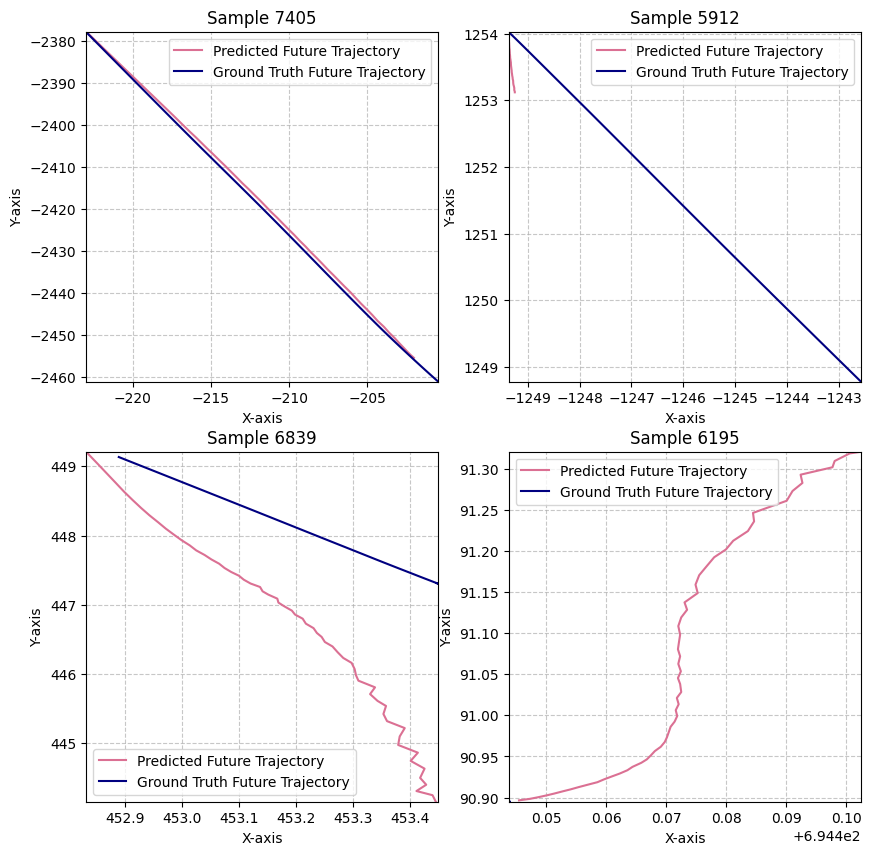

In [17]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)